<a href="https://colab.research.google.com/github/Pengchengzhi/Face-Alignment-DRF/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="#dd0000"> 0. To be Done </font><br /> 

* Section 2. load images, data loader

## less important:

* Section 3. picture format


# 1. Initialize

In [1]:
from google.colab import drive
drive.mount("/content/drive")

import os
path="/content/drive/My Drive/Face Alignment DRF"
os.chdir(path)
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['datasets',
 '__pycache__',
 '.ipynb_checkpoints',
 'utils',
 'DataPreprocessing.ipynb',
 'Procruses Analysis.ipynb',
 'PCA.ipynb',
 'Capsnet.ipynb',
 'main.ipynb']

In [2]:
!pip install kmeans_pytorch

In [3]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import cv2
import json
import pandas as pd
from PIL import Image
import torchvision.models as models
from scipy.stats import multivariate_normal
from torch.utils.data import Dataset, DataLoader
import math
import warnings
warnings.filterwarnings('ignore')
import pdb
from kmeans_pytorch import kmeans

In [4]:
from utils.network import *

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Dataset: 300W https://ibug.doc.ic.ac.uk/resources/300-W/

# 2. Data preparation

In [6]:
helen_train = np.load("datasets/cropped_helen/helen_train.npy") #(2000,20), train data after PCA
mean_shape = torch.from_numpy(np.load("datasets/cropped_helen/mean_shape.npy")).float().reshape(1,136).to(device) #(1,136) (x1, y1, x2, y2...)
eig_vecs = torch.from_numpy(np.load("datasets/cropped_helen/eig_vecs.npy")).float().to(device) #(20,136) the first 20 eigen vecs

In [7]:
with open("datasets/cropped_helen/helen_cropped_train_pts.json",'r') as htrain:
  htrain_pts = json.load(htrain)
with open("datasets/cropped_helen/helen_cropped_test_pts.json",'r') as htest:
  htest_pts = json.load(htest)

In [8]:
train_size = 200
test_size = 200

In [9]:
# Load pictures
train_tensor = torch.zeros((train_size,3,224,224))
train_label = torch.zeros((train_size,68,2))
i=0
for train_key in htrain_pts.keys():
  path = os.path.join("datasets/cropped_helen/trainset", train_key + '.jpg')
  pic = cv2.imread(path)
  pic = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)
  train_tensor[i,:,:,:] = torch.from_numpy(pic).permute(2,0,1)

  train_label[i,:,:] = torch.Tensor(htrain_pts[train_key])

  if (i+1)%40 == 0:
    print('Caught [%d/%d] pictures......' %(i+1,train_size))

  if i == train_size-1:
    break
  else: i+=1
train_tensor = train_tensor.to(device)
train_label = train_label.reshape(train_size,-1)
train_label[:,1::2] = 224 - train_label[:,1::2]
train_label = train_label.to(device)

Caught [40/200] pictures......
Caught [80/200] pictures......
Caught [120/200] pictures......
Caught [160/200] pictures......
Caught [200/200] pictures......


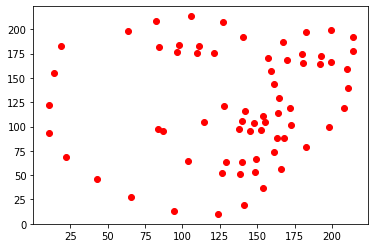

In [10]:
x = train_label[0][::2].cpu().detach().numpy()
y = train_label[0][1::2].cpu().detach().numpy()
plt.scatter(x,y,c='r',label='Sample train pts')

In [11]:
# Load pictures
test_tensor = torch.zeros((test_size,3,224,224))
test_label = torch.zeros((test_size,68,2))
i=0
for test_key in htest_pts.keys():
  path = os.path.join("datasets/cropped_helen/testset", test_key + '.jpg')
  pic = cv2.imread(path)
  pic = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)
  test_tensor[i,:,:,:] = torch.from_numpy(pic).permute(2,0,1)

  test_label[i,:,:] = torch.Tensor(htest_pts[test_key])

  if (i+1)%40 == 0:
    print('Caught [%d/%d] pictures......' %(i+1,test_size))

  if i == test_size-1:
    break
  else: i+=1
test_label = test_label.reshape(test_size,-1)
test_label[:,1::2] = 224-test_label[:,1::2]

Caught [40/200] pictures......
Caught [80/200] pictures......
Caught [120/200] pictures......
Caught [160/200] pictures......
Caught [200/200] pictures......


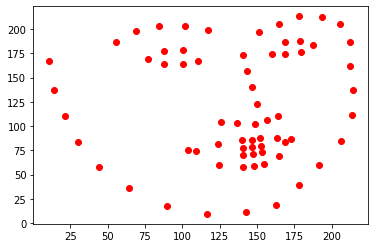

In [12]:
x = test_label[0][::2].cpu().detach().numpy()
y = test_label[0][1::2].cpu().detach().numpy()
plt.scatter(x,y,c='r',label='Sample test pts')

In [13]:
helen_train = helen_train/224
mean_shape = mean_shape/224

train_tensor = train_tensor/224
train_label = train_label/224
test_tensor = test_tensor/224
test_label = test_label/224

# 3. Sample pictures from train set

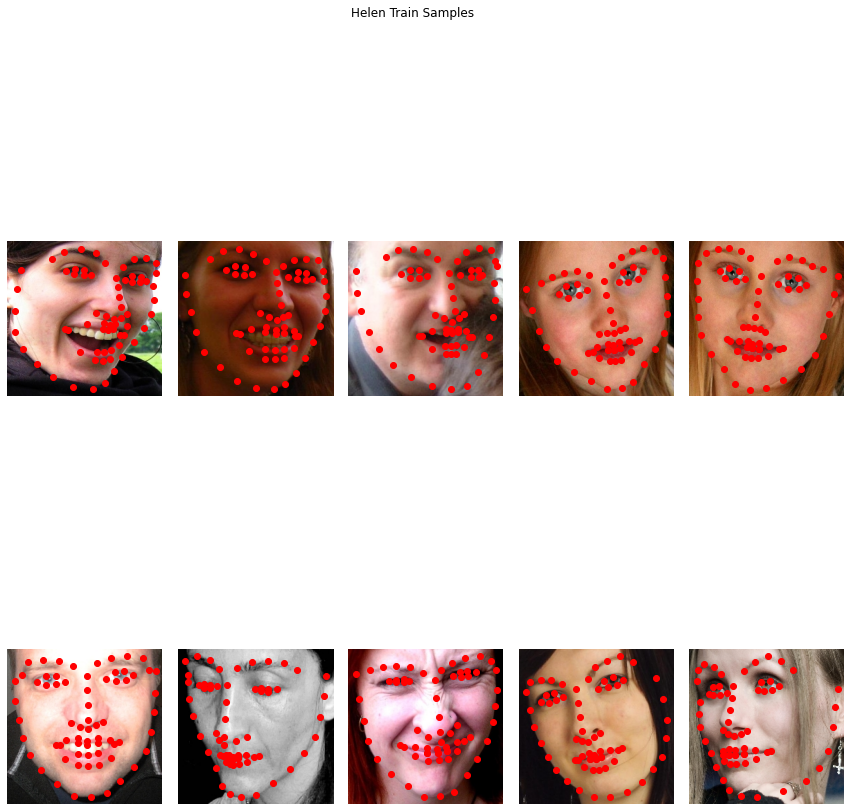

In [14]:
i=0
for key in htrain_pts.keys():
  if i==10: 
    break
  
  path_crop_pic = os.path.join("datasets/cropped_helen/trainset", key + '.jpg')

  crop_pic = cv2.imread(path_crop_pic)
  crop_pic = cv2.cvtColor(crop_pic, cv2.COLOR_BGR2RGB)

  crop_x = [htrain_pts[key][i][0] for i in range(68)]
  crop_y = [htrain_pts[key][i][1] for i in range(68)]

  plt.subplot(2,5,i+1) 
  plt.imshow(Image.fromarray(crop_pic))
  plt.scatter(crop_x,crop_y,color='r')
  plt.axis('off')
  i+=1
fig = plt.gcf()
plt.subplots_adjust(wspace=0.1, hspace=0.001)
fig.set_size_inches(15,15)
plt.suptitle('Helen Train Samples')
plt.show()

# 4. DRF Network

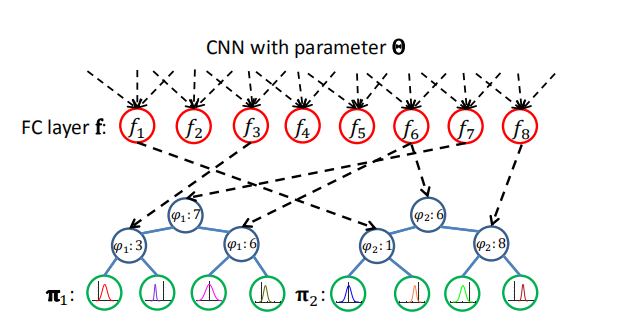

Use dim=*20* multivariate Gaussian X 8 to simulate.

# 5. Iterative training

In [15]:
def train_rf(train_data, in_states, device='cpu'):
  # train_data (200,20) // pi (8) // mu (8,20) // sigma (8,20,20)
  
  K = init_mu.shape[0]
  N = train_data.shape[0]
  pi, mu, sigma = in_states['pi'], in_states['mu'], in_states['sigma']
  gamma = torch.zeros(N,K).to(device)
  scores = torch.zeros(N,K).to(device)
  

  for iters in range(rf_iters):
    for k in range(K): # 8
      #print("Iters: %d, K: %d, \n " %(iters, k))
      #print("Covariance: ", sigma[k,:,:])
      m = torch.distributions.multivariate_normal.MultivariateNormal(mu[k,:], sigma[k,:,:])
      scores[:,k] = torch.exp(m.log_prob(train_data))*pi[k]
    
    #print("Scores",scores)
    gamma = scores/torch.sum(scores,axis=1,keepdims=True).float() # (200,8)
    #print('Gamma',gamma)

    pi = torch.sum(gamma,axis=0)/N
    mu = torch.matmul(gamma.T,train_data)/torch.sum(gamma,axis=0,keepdims=True).T
    for k in range(K):
      sigma[k,:,:] = torch.matmul((train_data-mu[k,:]).T,
              (train_data-mu[k,:])*gamma[:,[k]])/torch.sum(gamma,axis=0)[k]
    

    if (iters+1)%100 == 0 or iters == 0 :
      print('    RF:  Iter [%d/%d] // Prob: %d' \
            %(iters+1, rf_iters, torch.sum(scores).item()))
      

  states = {'pi': pi, 'mu': mu, 'sigma': sigma,}
  return states

In [16]:
def train_rf2(train_data, in_states, cnn_prob, device='cpu'):
  # train_data (200,20) // cnn_prob (200,8) // mu (8,20) // sigma (8,20,20)
  
  K = init_mu.shape[0]
  N = train_data.shape[0]
  pi, mu, sigma = in_states['pi'], in_states['mu'], in_states['sigma']
  gamma = torch.zeros(N,K).to(device)
  scores = torch.zeros(N,K).to(device)
  #themax = torch.zeros(K).to(device)
  

  for iters in range(rf_iters):
    for k in range(K): # 8
      m = torch.distributions.multivariate_normal.MultivariateNormal(mu[k,:], sigma[k,:,:])
      scores[:,k] = torch.exp(m.log_prob(train_data))*pi[k]
      #themax[k] = torch.exp(m.log_prob(mu[k,:]))
    
    scores = scores*cnn_prob
    gamma = scores/torch.sum(scores,axis=1,keepdims=True).float() # (200,8)
    
    #scores = scores/themax
    #scores = scores*pi
    #scores_weighted = scores * cnn_prob 
    #gamma = gamma
    #print('Gamma',gamma)

    pi = torch.sum(gamma,axis=0)/N
    mu = torch.matmul(gamma.T,train_data)/torch.sum(gamma,axis=0,keepdims=True).T
    for k in range(K):
      sigma[k,:,:] = torch.matmul((train_data-mu[k,:]).T,
              (train_data-mu[k,:])*gamma[:,[k]])/torch.sum(gamma,axis=0)[k]
    

    if (iters+1)%100 == 0 or iters == 0 :
      print('    RF:  Iter [%d/%d] // Prob: %d' \
            %(iters+1, rf_iters, torch.sum(scores).item()))
      

  states = {'pi': pi, 'mu': mu, 'sigma': sigma,}
  return states

In [17]:
def test_rf(states, test_data, device):
  pi, mu, sigma = states['pi'], states['mu'], states['sigma']
  K = pi.shape[0] # 8
  N = test_data.shape[0]
  probs = torch.zeros((N,K)).to(device)
  for k in range(K): # 8
    m_test = torch.distributions.multivariate_normal.MultivariateNormal(mu[k,:], sigma[k,:,:])
    probs[:,k] = torch.exp(m_test.log_prob(test_data))*pi[k]
  probs = probs/torch.sum(probs,axis=1,keepdims=True)
  return probs

In [18]:
def test_rf2(states, test_data, device):
  mu, sigma = states['mu'], states['sigma']
  K = mu.shape[0] # 8
  N = test_data.shape[0]
  probs = torch.zeros((N,K)).to(device)
  themax = torch.zeros(K).to(device)
  for k in range(K): # 8
    m_test = torch.distributions.multivariate_normal.MultivariateNormal(mu[k,:], sigma[k,:,:])
    probs[:,k] = torch.exp(m_test.log_prob(test_data))
    themax[k] = torch.exp(m_test.log_prob(mu[k,:]))
  probs = probs/themax

  return probs

In [19]:
def nme_ocular(predict, actual):
  # predict(N,136), predicted point locations
  # actual(N,136), actual point locations
  N = predict.shape[0]
  squared_dist = torch.sum((predict - actual)**2, dim=1) #(N)
  ocular_dist = torch.sqrt((actual[:,36]-actual[:,45])**2 + (actual[:,37]-actual[:,46])**2) # No.37 and No.46
  nme_ocular = torch.sum(squared_dist / ocular_dist)/N
  return nme_ocular.item()

In [39]:
Total_train = 3

# Init CNN
num_epochs = 2000
learning_rate = 0.01

layer1_cnn = CNN_module().to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(layer1_cnn.parameters(),lr=learning_rate)

# Init Regression Forest
rf_num = 8 # number of gaussian
rf_dim = 2 # dimension of multivariate gaussian

rf_iters = 300
train_label_rf = torch.from_numpy(helen_train[0:train_size,0:rf_dim]).float().to(device)

# Init states for gaussian
pi = torch.ones(rf_num)/rf_num

cluster_ids_x, cluster_centers = kmeans(X=train_label_rf, num_clusters=rf_num,device=device)
_, init_mu = kmeans(X=train_label_rf, num_clusters=rf_num,device=device)

init_sigma = torch.zeros(rf_num,rf_dim,rf_dim)
for i in range(rf_num):
  init_sigma[i,:,:] = torch.eye(rf_dim)

states = {}
states['pi'] = pi.to(device)
states['mu'] = init_mu.to(device)
states['sigma'] = init_sigma.to(device)

[running kmeans]: 10it [00:00, 244.76it/s, center_shift=0.000000, iteration=10, tol=0.000100]
[running kmeans]: 15it [00:00, 241.10it/s, center_shift=0.000000, iteration=15, tol=0.000100]

running k-means on cuda..
running k-means on cuda..


## Visualization for rf_dim=2

Text(0.5, 1.0, 'Train sample distribution and initial centers')

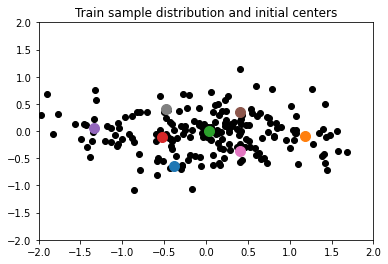

In [21]:
x = train_label_rf[:,0].cpu()
y = train_label_rf[:,1].cpu()
plt.scatter(x,y,c='k')

for i in range(rf_num):
  x = states['mu'][i,0].cpu()
  y = states['mu'][i,1].cpu()
  plt.scatter(x,y,marker='o',s=100)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.title('Train sample distribution and initial centers')

Text(0.5, 1.0, 'Initial Gaussian distribution')

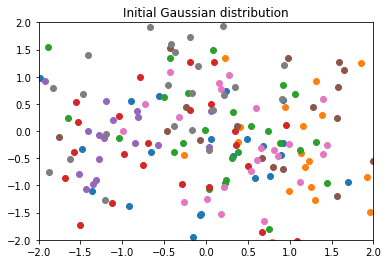

In [22]:
for i in range(rf_num):
  m = torch.distributions.multivariate_normal.MultivariateNormal(states['mu'][i,:].cpu(),states['sigma'][i,:,:].cpu())
  x = m.sample((25,))[:,0].cpu() 
  y = m.sample((25,))[:,1].cpu() 
  plt.xlim(-2,2)
  plt.ylim(-2,2)
  plt.scatter(x,y)
plt.title('Initial Gaussian distribution')

## Train sequentially

In [23]:
cnn_loss_hist = torch.zeros(num_epochs)
for round in range(Total_train):
  print("###########################################################")
  if torch.cuda.is_available():
    print("Round %d, Using GPU" %(round+1))
  else:
    print("Round ", round+1)
  

  # Train Regression Trees
  states = train_rf(train_label_rf, states, device)


  # Train CNN

  # Label for outputs2
  probs = test_rf(states, train_label_rf, device)

  for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = layer1_cnn(train_tensor) #(200,8)
    outputs2 = outputs/torch.sum(outputs,axis=1,keepdims=True)
    
    # Points predicted by CNN
    pred_value = torch.matmul(outputs2, states['mu'])
    points = (torch.matmul(pred_value, eig_vecs[:rf_dim,:])+mean_shape) #(200,136)

    loss = criterion(outputs2, probs)
    cnn_loss_hist[epoch] = loss.item()
    loss.backward()
    optimizer.step()
    if (epoch+1) % 100 == 0 or epoch == 0:
      print('    CNN: Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, loss.item()))
  

  print("NME(Ocular):", nme_ocular(points,train_label)*224)

###########################################################
Round 1, Using GPU
    RF:  Iter [1/200] // Prob: 19
    RF:  Iter [100/200] // Prob: 71
    RF:  Iter [200/200] // Prob: 82
    CNN: Epoch [1/2000], Loss: 0.3823
    CNN: Epoch [100/2000], Loss: 0.1793
    CNN: Epoch [200/2000], Loss: 0.1787
    CNN: Epoch [300/2000], Loss: 0.1786
    CNN: Epoch [400/2000], Loss: 0.1786
    CNN: Epoch [500/2000], Loss: 0.1786
    CNN: Epoch [600/2000], Loss: 0.1785
    CNN: Epoch [700/2000], Loss: 0.1785
    CNN: Epoch [800/2000], Loss: 0.1785
    CNN: Epoch [900/2000], Loss: 0.1784
    CNN: Epoch [1000/2000], Loss: 0.1764
    CNN: Epoch [1100/2000], Loss: 0.1597
    CNN: Epoch [1200/2000], Loss: 0.1306
    CNN: Epoch [1300/2000], Loss: 0.0979
    CNN: Epoch [1400/2000], Loss: 0.0707
    CNN: Epoch [1500/2000], Loss: 0.0528
    CNN: Epoch [1600/2000], Loss: 0.0434
    CNN: Epoch [1700/2000], Loss: 0.0434
    CNN: Epoch [1800/2000], Loss: 0.0392
    CNN: Epoch [1900/2000], Loss: 0.0341
    CNN

Text(0.5, 1.0, 'CNN Training Loss')

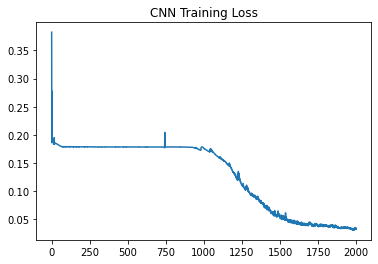

In [24]:
plt.plot(torch.arange(num_epochs),cnn_loss_hist)
plt.title('CNN Training Loss')

# Training using train_rf2

In [40]:
for round in range(Total_train):
  print("###########################################################")
  if torch.cuda.is_available():
    print("Round %d, Using GPU" %(round+1))
  else:
    print("Round ", round+1)
  
  if round == 0:
    outputs2 = torch.ones(200,8).to(device)/8


  # Train Leaf Node
  with torch.no_grad():
    states = train_rf2(train_label_rf, states, outputs2, device)


  # Train CNN
  probs = test_rf2(states, train_label_rf, device)
  N = outputs2.shape[0]
  label = torch.zeros(outputs2.shape).to(device)
  label[torch.arange(N),torch.argmax(probs,1)] = 1

  for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = torch.abs(layer1_cnn(train_tensor)) #(200,8)
    outputs2 = outputs/torch.sum(outputs, axis=1, keepdims=True)
    
    
    if round == 0:
      loss = criterion(outputs2, label)
    else:
      pred_value = torch.sum(outputs2*probs, axis=1)/probs.shape[1]
      loss = -torch.sum(torch.log(pred_value))/N
    loss.backward()
    optimizer.step()

    if (epoch+1) % 200 == 0 or epoch == 0:
      print('    CNN: Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, loss.item()))
  
  
  weighted_mean = torch.matmul(outputs2, states['mu'])
  points = (torch.matmul(weighted_mean, eig_vecs[:rf_dim,:])+mean_shape) #(200,136)
  print("NME(Ocular):", nme_ocular(points,train_label)*224)

###########################################################
Round 1, Using GPU
    RF:  Iter [1/300] // Prob: 2
    RF:  Iter [100/300] // Prob: 8
    RF:  Iter [200/300] // Prob: 9
    RF:  Iter [300/300] // Prob: 9
    CNN: Epoch [1/2000], Loss: 0.2251
    CNN: Epoch [200/2000], Loss: 0.1883
    CNN: Epoch [400/2000], Loss: 0.1879
    CNN: Epoch [600/2000], Loss: 0.1878
    CNN: Epoch [800/2000], Loss: 0.1877
    CNN: Epoch [1000/2000], Loss: 0.1878
    CNN: Epoch [1200/2000], Loss: 0.1876
    CNN: Epoch [1400/2000], Loss: 0.1877
    CNN: Epoch [1600/2000], Loss: 0.1877
    CNN: Epoch [1800/2000], Loss: 0.1877
    CNN: Epoch [2000/2000], Loss: 0.1877
NME(Ocular): 336.29747009277344
###########################################################
Round 2, Using GPU
    RF:  Iter [1/300] // Prob: 13


ValueError: ignored

In [38]:
outputs2

tensor([[ 0.9868, -0.0056, -0.0015,  ...,  0.0449, -0.0110, -0.0119],
        [-0.0822, -0.0281,  0.3472,  ...,  0.8146, -0.0173, -0.0393],
        [-0.1199, -0.0274,  0.3826,  ...,  0.8095, -0.0223, -0.0034],
        ...,
        [ 1.0215,  0.0087, -0.0058,  ..., -0.0158, -0.0088,  0.0083],
        [-0.0420,  0.0778,  0.3201,  ...,  0.3652,  0.0750,  0.1079],
        [ 1.0267,  0.0013, -0.0095,  ..., -0.0045, -0.0027, -0.0144]],
       device='cuda:0', grad_fn=<DivBackward0>)

## Trained Gaussian Visualization for rf_dim=2

Text(0.5, 1.0, 'Train samples and trained centers')

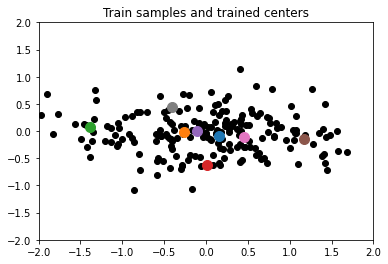

In [23]:
x = train_label_rf[:,0].cpu()
y = train_label_rf[:,1].cpu()
plt.scatter(x,y,c='k')

for i in range(rf_num):
  x = states['mu'][i,0].cpu()
  y = states['mu'][i,1].cpu()
  plt.scatter(x,y,marker='o',s=100)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.title('Train samples and trained centers')

In [34]:
cov = states['sigma'][4,:,:].cpu()
mean = states['mu'][4,:].cpu()

In [37]:
np.linalg.svd(cov)

(array([[-0.89540833,  0.44524592],
        [ 0.44524592,  0.89540833]], dtype=float32),
 array([1.1471735e+00, 2.6830886e-09], dtype=float32),
 array([[-0.89540833,  0.44524592],
        [-0.44524592, -0.89540833]], dtype=float32))

In [36]:
np.matmul(invcov,cov)

tensor([[ 8.2751, -1.5818],
        [-6.2718,  4.3827]])

ValueError: ignored

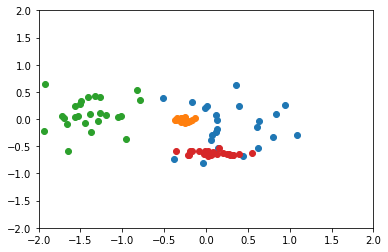

In [24]:
for i in range(rf_num):

  m = torch.distributions.multivariate_normal.MultivariateNormal(states['mu'][i,:].cpu(),states['sigma'][i,:,:].cpu())
  x = m.sample((25,))[:,0].cpu() 
  y = m.sample((25,))[:,1].cpu() 
  plt.xlim(-2,2)
  plt.ylim(-2,2)
  plt.scatter(x,y)

plt.title('Trained Gaussian distribution')

## Visualize train sample

Text(0.5, 1.0, 'Train sample')

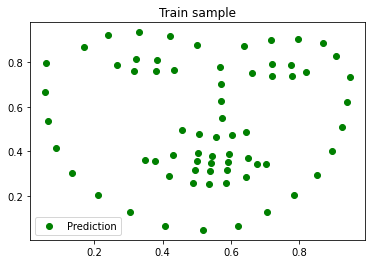

In [ ]:
ith = 2

x1 = points[ith][::2].cpu().detach().numpy()
y1 = points[ith][1::2].cpu().detach().numpy()
plt.scatter(x1,y1,c='g',label='Prediction')

points2 = torch.matmul(train_label_rf[:,0:rf_dim].cpu(), eig_vecs[0:rf_dim,:].cpu())+mean_shape.cpu()

x2 = points2[ith][::2].cpu().detach().numpy()
y2 = points2[ith][1::2].cpu().detach().numpy()
#plt.scatter(x2,y2,c='r',label='Train should be')

plt.legend()
plt.title("Train sample")

# 6. Test

In [ ]:
with torch.no_grad():
  test_outputs = layer1_cnn(test_tensor.to(device))
test_outputs2 = test_outputs/torch.sum(test_outputs,axis=1,keepdims=True)
test_pred_value = torch.matmul(test_outputs2, states['mu'])
test_points = (torch.matmul(test_pred_value, eig_vecs[:rf_dim,:])+mean_shape) #(200,136)

Text(0.5, 1.0, 'Test time')

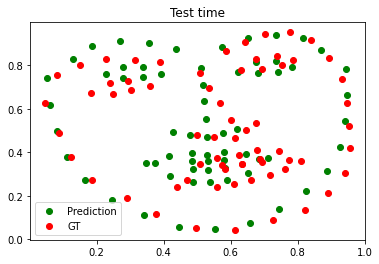

In [ ]:
jth = 50

x1 = test_points[jth][::2].cpu().detach().numpy()
y1 = test_points[jth][1::2].cpu().detach().numpy()
plt.scatter(x1,y1,c='g',label='Prediction')

test_points2 = torch.matmul(train_label_rf[:,0:rf_dim].cpu(), eig_vecs[0:rf_dim,:].cpu())+mean_shape.cpu()

x2 = test_label[jth][::2].cpu().detach().numpy()
y2 = test_label[jth][1::2].cpu().detach().numpy()
plt.scatter(x2,y2,c='r',label='GT')

plt.legend()
plt.title("Test time")